In [279]:
import sys
import os
sys.path.insert(0, os.path.abspath('../'))
sys.path.insert(0, os.path.abspath('../../'))
sys.path.insert(0, os.path.abspath('/home/hm-tlacherm/qlm_notebooks/notebooks_1.2.1/notebooks/master_thesis_qaoa/'))
sys.path.insert(0, os.path.abspath('/home/hm-tlacherm/qlm_notebooks/notebooks_1.2.1/notebooks/master_thesis_qaoa/ibm/'))

In [280]:
import numpy as np

import qiskit
provider = qiskit.IBMQ.load_account()
from qiskit import Aer
from qiskit.utils import QuantumInstance
from qiskit_optimization.algorithms import MinimumEigenOptimizer
from qiskit.algorithms import QAOA
from shared.QiskitMaxcut import *
from ibm.ibm_parameters import *

from matplotlib import pyplot as plt
%matplotlib inline

ibmqfactory.load_account:WARNING:2021-08-25 07:22:52,004: Credentials are already in use. The existing account in the session will be replaced.


In [281]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


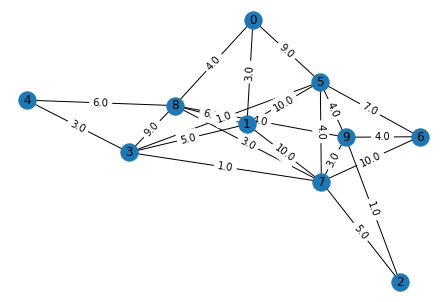

In [426]:
# ---- Define graph and MaxCut ----
#graph = generate_butterfly_graph(with_weights=True)
#graph = load_nx_graph_from("/home/hm-tlacherm/qlm_notebooks/notebooks_1.2.1/notebooks/master_thesis_qaoa/data/graphs/16_nodes/graph_16_33_01_w.txt")
graph = load_nx_graph_from("/home/hm-tlacherm/qlm_notebooks/notebooks_1.2.1/notebooks/master_thesis_qaoa/data/graphs/10_nodes/graph_10_22_01_w.txt")

max_cut = Maxcut(graph)
max_cut_qubo = max_cut.to_qubo()
max_cut.draw()

In [105]:
from qiskit_optimization.algorithms import RecursiveMinimumEigenOptimizer, IntermediateResult

In [106]:
quantum_instance = QuantumInstance(
                    backend=Aer.get_backend(DEFAULT_QASM_SIMULATOR),
                    shots=SHOTS
)

In [346]:
quantum_instance_ibmq = QuantumInstance(
                    backend=provider.get_backend('ibmq_toronto'),
                    shots=SHOTS
)

In [354]:
BACKEND_NAME = 'ibmq_toronto'
provider = qiskit.IBMQ.get_provider(hub='ibm-q-unibw', group='hochschule-muc', project='masterarbeit')
noise_backend = provider.get_backend(BACKEND_NAME)
noise_model = NoiseModel.from_backend(noise_backend)
coupling_map = noise_backend.configuration().coupling_map
basis_gates = noise_model.basis_gates

In [355]:
# Import measurement calibration functions
from qiskit.ignis.mitigation.measurement import (complete_meas_cal, tensored_meas_cal,
                                                 CompleteMeasFitter, TensoredMeasFitter)
quantum_instance_noise = QuantumInstance(
                backend=provider.get_backend('ibmq_qasm_simulator'),
                shots=SHOTS,
                noise_model=noise_model,
                coupling_map=coupling_map,
                basis_gates=basis_gates,
                measurement_error_mitigation_cls=CompleteMeasFitter,
                measurement_error_mitigation_shots=SHOTS
)

In [445]:
qaoa = QAOA(optimizer=COBYLA(maxiter=0),
            quantum_instance=quantum_instance,
            reps=1,
            #initial_point=[0.02, 0.06, 0.1 , 0.14, 0.18, 0.22, 0.26, 0.3 , 0.34, 0.38, 0.38, 0.34, 0.3 , 0.26, 0.22, 0.18, 0.14, 0.1 , 0.06, 0.02]
           )

In [451]:
from qiskit_optimization.algorithms import WarmStartQAOAOptimizer, CobylaOptimizer, MinimumEigenOptimizer, GroverOptimizer,  SlsqpOptimizer
from shared.Mitiq_QAOA import *
ws_qaoa = WarmStartQAOAOptimizer(pre_solver=CobylaOptimizer(), relax_for_pre_solver=True, qaoa=qaoa, epsilon=0.001)

#result = ws_qaoa.solve(max_cut_qubo)

In [452]:
#algorithm = MinimumEigenOptimizer(qaoa)
optimizer = RecursiveMinimumEigenOptimizer(ws_qaoa, history=IntermediateResult.ALL_ITERATIONS)
result =  ws_qaoa.solve(max_cut_qubo) # optimizer.solve(max_cut_qubo)

In [442]:
result.history

AttributeError: 'MinimumEigenOptimizationResult' object has no attribute 'history'

In [443]:
optimal_parameters = qaoa.optimal_params
print(f"Optimal Parameters: {optimal_parameters}")

Optimal Parameters: [ 0.44396801 -5.6295232 ]


optimal function value: -89.0
optimal value: [1. 1. 1. 1. 1. 0. 1. 0. 0. 1.]
status: SUCCESS
Number of samples (36) is too large to display. Skip.
Expectation Value: -87.66775000000004
Highest Exp.Value: -36 with 0.000125
Lowest Exp.Value: -89 with 0.90838
Highest Probability: -89 with 0.90838
Ratio r: 0.9748632075471706
MSE: 452.28809839583477
RMSE: 21.267066050488364


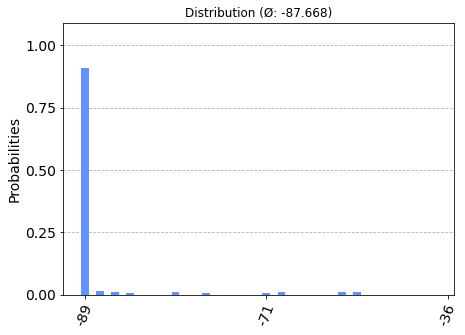

In [453]:
mean, distribution = max_cut.analyse(result, print_output=True)
max_cut.plot_histogram(distribution, mean)

In [363]:
qaoa = QAOA(optimizer=COBYLA(maxiter=0),
            quantum_instance=quantum_instance,
            reps=1,
            #initial_point=[0.02, 0.06, 0.1 , 0.14, 0.18, 0.22, 0.26, 0.3 , 0.34, 0.38, 0.38, 0.34, 0.3 , 0.26, 0.22, 0.18, 0.14, 0.1 , 0.06, 0.02]
           )

In [364]:
algorithm = MinimumEigenOptimizer(qaoa)
result = algorithm.solve(max_cut_qubo)

optimal function value: -89.0
optimal value: [0. 0. 0. 0. 0. 1. 0. 1. 1. 0.]
status: SUCCESS
Number of samples (894) is too large to display. Skip.
Expectation Value: -54.113000000000056
Highest Exp.Value: 0 with 0.001625
Lowest Exp.Value: -89 with 0.000125
Highest Probability: -59 with 0.047875
Ratio r: 0.6080112359550568
MSE: 495.7763182957752
RMSE: 22.266035082514694


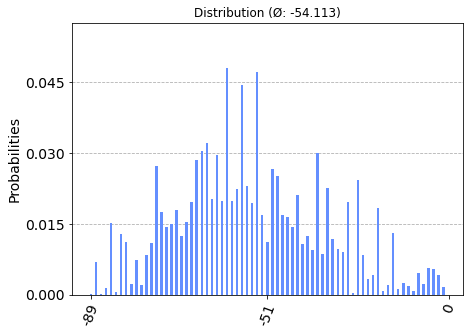

In [365]:
mean, distribution = max_cut.analyse(result, print_output=True)
max_cut.plot_histogram(distribution, mean)